# 卷积神经网络的应用

欢迎来到课程4的第二项作业！在此笔记本中，你将：

- 实现模型构建所需的辅助函数
- 使用TensorFlow实现功能全面的ConvNet

**完成此作业后，你将能够：**

- 用TensorFlow构建和训练ConvNet解决分类问题

我们在这里假设你已经熟悉TensorFlow。如果不是，请先学习课程2第三周的*TensorFlow教程*（“*改善深度神经网络*”）。

## 1 TensorFlow模型

在上一项作业中，你使用numpy构建了辅助函数，以了解卷积神经网络背后的机制。实际上现在大多数深度学习的应用都是使用编程框架构建的，框架具有许多内置函数，你可以轻松地调用它们。

和之前一样，我们将从加载包开始。

In [1]:
cd ../data/L4W1

G:\deep learning\deeplearning.ai\data\L4W1


In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

运行以下单元格以加载要使用的“SIGNS”数据集。

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

SIGNS数据集是6个手势符号的图片集，这些符号表示从0到5的数字。

![Image](../image/L4W1/9.png)


以下单元格将显示数据集中标记图像的示例。随时更改`index`的值，然后重新运行以查看不同的示例。

y = 2


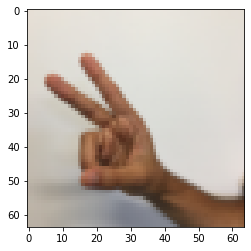

In [4]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

在课程2中，你已经为此数据集构建了一个全连接的网络。但是由于这是图像数据集，因此应用ConvNet将更自然。

首先，让我们检查数据的维度。

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 创建占位符

TensorFlow需要为运行会话时输入的数据创建占位符。

**练习**：实现以下函数为输入图像X和输出Y创建占位符。暂时不用定义训练数据的数量。为此，你可以使用 "None" 作为批次大小，稍后灵活地选择它。因此，X的维度应为 **[None, n_H0, n_W0, n_C0]**，Y的尺寸应为 **[None, n_y]**。 [提示](https://www.tensorflow.org/api_docs/python/tf/placeholder)。

In [6]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    ### END CODE HERE ###
    
    return X, Y

In [7]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


**预期输出**
X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)

### 1.2 初始化参数

你将使用`tf.contrib.layers.xavier_initializer（seed = 0）`初始化权重/滤波器$W1$和$W2$。你无需担心偏差变量，因为TensorFlow函数可以处理偏差。还要注意你只会为conv2d函数初始化权重/滤波器，TensorFlow将自动初始化全连接部分的层。在本作业的后面，我们将详细讨论。

**练习**:实现initialize_parameters(),下面提供了每组过滤器的尺寸。
**提示**：在Tensorflow中初始化维度为[1,2,3,4]的参数$W$，使用：
```python
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```
[More Info](https://www.tensorflow.org/api_docs/python/tf/get_variable)。

In [8]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 =tf.get_variable('W1',[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


**预期输出:**
W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]

### 1.3 正向传播

在TensorFlow中，有内置函数为你执行卷积步骤。

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** 给定输入$X$和一组滤波器$W1$，函数将使用$W1$的滤波器卷积X。第三个输入([1,f,f,1])表示输入的每个维度(m, n_H_prev, n_W_prev, n_C_prev)的步幅。你可以在[here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)阅读完整的文档。

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** 给定输入A，此函数使用大小为（f，f）的窗口和大小为（s，s）的步幅在每个窗口上进行最大池化。你可以在 [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)阅读完整的文档。

- **tf.nn.relu(Z1):** 计算Z1的ReLU激活输出（可以是任何形状）。你可以在 [here](https://www.tensorflow.org/api_docs/python/tf/nn/relu)阅读完整的文档。

- **tf.contrib.layers.flatten(P)**: 给定输入P，此函数将每个示例展平为一维向量，同时保持批量大小。它返回维度为[batch_size，k]的展平张量。你可以在 [here](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)阅读完整的文档。

- **tf.contrib.layers.fully_connected(F, num_outputs):** 给定展平的输入F，它将返回用全连接层计算出的输出。你可以在 [here](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)阅读完整的文档。

在上面的最后一个函数（`tf.contrib.layers.fully_connected`）中，全连接层会自动初始化图中的权重，并在训练模型时继续对其进行训练。因此，初始化参数时无需初始化这些权重。

**练习**：

实现下面的`forward_propagation`函数以构建以下模型：`CONV2D-> RELU-> MAXPOOL-> CONV2D-> RELU-> MAXPOOL-> FLATTEN-> FULLYCONNECTED`。使用上面那些函数。
	 
具体地，我们将在所有步骤中使用以下参数：
     - Conv2D：步幅为1，填充为“SAME”
     - ReLU
     - Max pool：使用8x8的滤波器和8x8的步幅，填充为“SAME”
     - Conv2D：步幅为1，填充为“SAME”
     - ReLU
     - Max pool：使用4x4的滤波器和4x4的步幅，填充为“SAME”
     - 展平之前的输出。
     - FULLYCONNECTED（FC）层：应用不含非线性激活函数的全连接层。请勿在此处调用softmax。这将在输出层中产生6个神经元，然后将其传递给softmax。在TensorFlow中，softmax和cost函数被合并为一个函数，在计算损失时将调用另一个函数。

In [27]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    print("X = ", X)
    print("W1 = ", W1)
    print("Z1 =", Z1)
    print("A1 =", A1)
    print("P1 =", P1)
    print("W2 = ", W2)
    print("Z2 =", Z2)
    print("A2 =", A2)
    print("P2 =", P2)

    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 6, activation_fn=None)
    ### END CODE HERE ###

    
    print("P2 =", P2)
    print("Z3 =", Z3)

    
    return Z3

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " ,a)

X =  Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
W1 =  <tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
Z1 = Tensor("Conv2D:0", shape=(?, 64, 64, 8), dtype=float32)
A1 = Tensor("Relu:0", shape=(?, 64, 64, 8), dtype=float32)
P1 = Tensor("MaxPool:0", shape=(?, 8, 8, 8), dtype=float32)
W2 =  <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>
Z2 = Tensor("Conv2D_1:0", shape=(?, 8, 8, 16), dtype=float32)
A2 = Tensor("Relu_1:0", shape=(?, 8, 8, 16), dtype=float32)
P2 = Tensor("MaxPool_1:0", shape=(?, 2, 2, 16), dtype=float32)
P2 = Tensor("Flatten/flatten/Reshape:0", shape=(?, 64), dtype=float32)
Z3 = Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
Z3 =  [[ 1.4416982  -0.24909675  5.4504995  -0.26189643 -0.2066989   1.3654672 ]
 [ 1.4070848  -0.02573231  5.0892797  -0.48669893 -0.40940714  1.2624854 ]]


**预期输出**:
Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]

### 1.4 计算损失

在下面实现损失函数的计算，你可能会发现以下两个函数很有帮助：

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** 计算softmax熵损失，该函数会计算softmax激活函数以及由此产生的损失。你可以在 [here](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)查看完整的文档。
- **tf.reduce_mean:** 计算张量各维度上元素的均值，用它来对所有训练示例的损失求和，以获得总损失，你可以在[here](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)查看完整的文档。

**练习**：使用上面的函数计算下述损失。

In [31]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

In [33]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

X =  Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
W1 =  <tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
Z1 = Tensor("Conv2D:0", shape=(?, 64, 64, 8), dtype=float32)
A1 = Tensor("Relu:0", shape=(?, 64, 64, 8), dtype=float32)
P1 = Tensor("MaxPool:0", shape=(?, 8, 8, 8), dtype=float32)
W2 =  <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>
Z2 = Tensor("Conv2D_1:0", shape=(?, 8, 8, 16), dtype=float32)
A2 = Tensor("Relu_1:0", shape=(?, 8, 8, 16), dtype=float32)
P2 = Tensor("MaxPool_1:0", shape=(?, 2, 2, 16), dtype=float32)
P2 = Tensor("Flatten/flatten/Reshape:0", shape=(?, 64), dtype=float32)
Z3 = Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
cost = 4.6648703


**预期输出**: 
cost =4.6648703

### 1.5 构建模型

最后，你将合并以上实现的辅助函数以构建模型并在SIGNS数据集上对其进行训练。

你已经在课程2的“优化算法”编程作业中实现了`random_mini_batches()`，记住此函数返回的是一个小批次的处理列表。

**练习**：完成以下函数：

以下模型应：

- 创建占位符
- 初始化参数
- 正向传播
- 计算损失
- 创建优化函数

最后，你将创建一个会话并为num_epochs运行一个for循环，获取小批次处理，然后针对每个小批次运行优化函数。
[Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer) 

In [34]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

运行以下单元格以训练模型100个epoch。检查第0和第5个阶段之后的损失是否与我们的输出匹配。如果不是，请停止单元格并检查你的代码！

X =  Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
W1 =  <tf.Variable 'W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
Z1 = Tensor("Conv2D:0", shape=(?, 64, 64, 8), dtype=float32)
A1 = Tensor("Relu:0", shape=(?, 64, 64, 8), dtype=float32)
P1 = Tensor("MaxPool:0", shape=(?, 8, 8, 8), dtype=float32)
W2 =  <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>
Z2 = Tensor("Conv2D_1:0", shape=(?, 8, 8, 16), dtype=float32)
A2 = Tensor("Relu_1:0", shape=(?, 8, 8, 16), dtype=float32)
P2 = Tensor("MaxPool_1:0", shape=(?, 2, 2, 16), dtype=float32)
P2 = Tensor("Flatten/flatten/Reshape:0", shape=(?, 64), dtype=float32)
Z3 = Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32)
Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784094
Cost after epoch 30: 1.687816
Cost after epoch 35: 1.617915
Cost after epoch 40: 1.588564
Cost after epoch 45: 1.564675
C

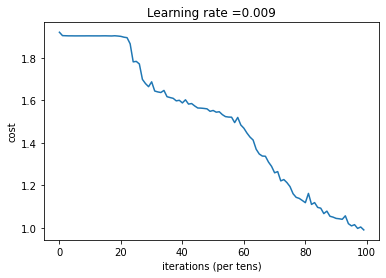

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.675
Test Accuracy: 0.55


In [35]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

**预期输出**: 
尽管它可能无法完美匹配，但是你的预期输出应该接近我们的预期，并且你的损失值应该降低。
Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
...
Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156


Train Accuracy: 0.6638889
Test Accuracy: 0.55

Nice！你已经完成了作业并建立了一个模型，该模型可以在测试集上以几乎80％的精度识别SIGN手势，如果你愿意，可以随时使用此数据集。实际上，你可以通过花费更多时间调整超参数或使用正则化来提高其准确性（因为该模型显然具有很高的方差）。

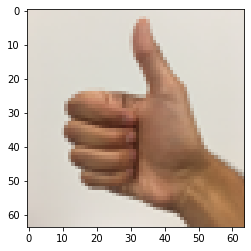

In [43]:
fname = "thumbs_up.jpg"
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize((64,64)))
plt.imshow(my_image)